In [ ]:
"""
Try to make a Tensorflow version
In this notebook, we're going to go through how to use data generator.
# Why using data generator
-- You cannot load everything into the RAM!!!

"""

In [1]:
"""
Import basic libraries
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import re

from PIL import Image
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.contrib import learn


In [2]:
"""
Define shared functions
"""
def op_img(x, im_size):
    # x: image path list (of a batch)
    # im_size:tuple (w,h,c)
    w,h,c = im_size
    X_ = np.array([np.array(Image.open(i).resize((w, h)), dtype='float32') for i in x])
    if c == 1:
        X_ = np.expand_dims(X_, axis = 3)
    else:
        pass
    return X_



In [3]:
"""
Make datatable
"""
d_train = "dataset/train/"
d_test = "dataset/test1/"
d_aug_out = "dataset/augment/"

img_train_list = glob.glob(d_train + "*.jpg")
img_test_list = glob.glob(d_test + "*.jpg")

### make datatable 
df_train = pd.DataFrame({'img_path': img_train_list})
df_test = pd.DataFrame({'img_path': img_test_list})

# expand df
df_train['cate'] = df_train.img_path.apply(os.path.basename)
df_train['cate'] = [i.split(".")[0] for i in list(df_train.cate)]

df_train.head()

,img_path,cate
0,dataset/train\cat.0.jpg,cat
1,dataset/train\cat.1.jpg,cat
2,dataset/train\cat.10.jpg,cat
3,dataset/train\cat.100.jpg,cat
4,dataset/train\cat.1000.jpg,cat


In [ ]:
"""
Define Image generator parameter
"""


In [4]:
"""
Write a class function for generator
"""
class call_generator():
    def __init__(self, params_dict, dta_gen = None):
        self.tags = params_dict['tags']
        self.im_w, self.im_h = params_dict['im_w'], params_dict['im_h']
        self.channels = params_dict['im_c']
        self.data_gen = dta_gen
    #
    
    def train_generator(self, bz, 
                        df_class0, df_class1, 
                        class_0_ratio = 1, class_1_ratio = 1):
        while(1):
            per_get = bz / len(self.tags)
            X_ = []
            Y_ = []
            
            # get balanced input for each mini-batch
            i_get_0 = df_class0.sample(n = int(per_get * class_0_ratio))
            i_get_1 = df_class1.sample(n = int(per_get * class_0_ratio))
            i_get = pd.concat((i_get_0, i_get_1))
            
            X_ = list(i_get.img_path)
            Y_ = list(i_get.cate)
            
            # open image array
            X_ = op_img(X_, (self.im_w, self.im_h, self.channels))
            
            # make y into one-hot-encoding
            le = preprocessing.LabelEncoder()
            le.fit(self.tags)
            Y_ = le.transform(Y_)
            Y_ = np.eye(len(self.tags))[Y_]
            #Y_ = tf.one_hot(Y_, depth= len(self.tags))
            
            if self.data_gen is None:
                pass
            else:
                datagen = self.data_gen
                datagen.fit(X_) # if there is no special transform, you can skip this line
                for X_, Y_ in datagen.flow(X_, Y_, batch_size= len(X_)):
                    # only do it once
                    break
            #X_ = X_.astype('float32')
            X_ = X_.astype('uint8')
            """
            Add your other hand-craft preprocessing function here
            for example, -imagenet mean, -dataset mean ...
            we don't need preproc in this case
            """
            
            # finally, we yield data
            yield X_, Y_
    
    def get_validation(self, df_class0, df_class1, 
                       class_0_ratio = 1, class_1_ratio = 1, 
                       use_im_gen = None, n_gen_loop = 3):
        X_ = []
        Y_ = []
        per_get = len(df_class1)
        
        i_get_0 = df_class0.sample(n = int(per_get * class_0_ratio) )
        i_get_1 = df_class1
        i_get = pd.concat((i_get_0, i_get_1))
        
        X_ = list(i_get.img_path)
        Y_ = list(i_get.cate)
        print(len(X_))
        
        X_ = op_img(X_, (self.im_w, self.im_h, self.channels))
        le = preprocessing.LabelEncoder()
        le.fit(self.tags)
        Y_ = le.transform(Y_)
        #Y_ = tf.one_hot(Y_, depth=len(self.tags))
        Y_ = np.eye(len(self.tags))[Y_]
        
        if use_im_gen is None:
            pass
        else:
            datagen = use_im_gen
            datagen.fit(X_)
            i_start = 1
            i_end = n_gen_loop
            if i_end > 0:
                for X_gen, Y_gen in datagen.flow(X_, Y_, batch_size=len(X_), shuffle=False):
                    X_ = np.concatenate((X_, X_gen))
                    Y_ = np.concatenate((Y_, Y_gen))
                    if i_start == i_end:
                        break
                    i_start += 1
        print(X_.shape)
        X_ = X_.astype('uint8')
        #X_ = X_.astype('float32')
        """
        Add your other hand-craft preprocessing function here
        for example, -imagenet mean, -dataset mean ...
        we don't need preproc in this case
        """
        return X_, Y_
                

In [5]:
"""
Data and model parameter init
"""
im_w, im_h, im_c = 120, 120, 3
mini_mode = True

if mini_mode:
    nb_epoch = 10
    nb_updates_per_epoch = 50
else:
    nb_epoch = 100
    nb_updates_per_epoch = 250


generator_params = {'tags': ['cat', 'dog'], 
               'im_w': im_w, 'im_h': im_h, 'im_c': im_c}

gen_data = call_generator(generator_params, dta_gen = None)

df_train_0, df_val_0 = train_test_split(df_train[df_train['cate'] == 'cat'], test_size = 0.05)
df_train_1, df_val_1 = train_test_split(df_train[df_train['cate'] == 'dog'], test_size = 0.05)

x_val, y_val = gen_data.get_validation(df_class0= df_val_0, df_class1= df_val_1, 
                                       class_0_ratio=1, class_1_ratio=1, use_im_gen = None)

1250
(1250, 120, 120, 3)


In [ ]:
"""
Demo of generator output (useful for debugging)
"""
gen_data = call_generator(generator_params, dta_gen = None)
tmp = gen_data.train_generator(df_class0=df_train_0, df_class1=df_train_1, bz=bz)
a,b = next(tmp)
print(a.shape)
print(b.shape)

In [6]:
"""
Define model
"""

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev= 0.1)
    return tf.Variable(initial)
    
def bias_variable(shape):
    initial = tf.truncated_normal(shape, stddev= 0.1)
    return tf.Variable(initial)
    
def conv2D(x, W):
    # x: input
    # W: shape
    return tf.nn.conv2d(x, W, strides = [1, 1, 1, 1], padding = 'SAME')
    
def max_pool(x, size):
    # x: input
    # size: tuple of shape, e.g. (2,2)
    sx, sy = size
    return tf.nn.max_pool(x, ksize=[1, sx, sy, 1], 
                             strides=[1, sx, sy, 1], padding = 'SAME')

In [21]:
x_ = tf.placeholder(tf.float32, [None, im_w, im_h, im_c])
y_ = tf.placeholder(tf.float32, [None, 2])

# c64, c128, c128, c512 -> d128 -> output
#x_ = tf.reshape(x_, [-1, im_w, im_h, im_c])

W_conv1 = weight_variable([3, 3, 3, 64])
b_conv1 = bias_variable([64])
h_conv1 = tf.nn.relu(tf.add(conv2D(x_, W_conv1), b_conv1))
h_pool1 = max_pool(h_conv1, (2,2))

W_conv2 = weight_variable([3, 3, 64, 128])
b_conv2 = bias_variable([128])
h_conv2 = tf.nn.relu(tf.add(conv2D(h_pool1, W_conv2),b_conv2))
h_pool2 = max_pool(h_conv2, (2,2))

W_conv3 = weight_variable([3, 3, 128, 256])
b_conv3 = bias_variable([256])
h_conv3 = tf.nn.relu(tf.add(conv2D(h_pool2, W_conv3), b_conv3))
h_pool3 = max_pool(h_conv3, (2,2))

flat = tf.reshape(h_pool3, [-1, 15 * 15 * 256])

W_fc1 = weight_variable([15 * 15 * 256, 32])
b_fc1 = bias_variable([32])
h_fc1 = tf.nn.relu(tf.add(tf.matmul(flat, W_fc1), b_fc1))

keep_prob = tf.placeholder(tf.float32)
h_hc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([32, 2])
b_fc2 = bias_variable([2])

output = tf.add(tf.matmul(h_hc1_drop, W_fc2), b_fc2)
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=output))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(output, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 
                                  tf.float32))

In [107]:
tmp

<tf.Tensor 'Reshape_73:0' shape=(?,) dtype=float32>

In [22]:
steps = 6000
batch_size = 24

train_gen = gen_data.train_generator(bz=batch_size, df_class0=df_train_0, df_class1=df_train_1)

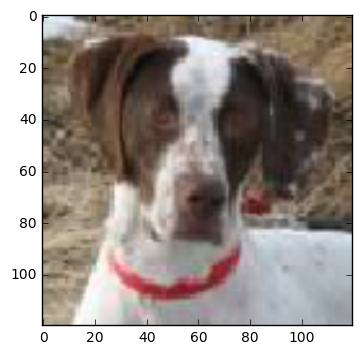

In [77]:
batch = next(train_gen)
plt.imshow(batch[0][9])
plt.show()

In [23]:
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print('initiaize')
    for i in range(steps):
        batch = next(train_gen)
        if i % 100 == 0:
            loss_t, acc_t= sess.run([cross_entropy, accuracy],
                                         feed_dict = {x_: batch[0],
                                                      y_: batch[1],
                                                      keep_prob: 0.8})
            print('step %d, training accuracy = %g, loss = %g' % (i, acc_t, loss_t))
        
        """
        if i % 1000 == 0:
            loss_v, acc_v= sess.run([cross_entropy, accuracy],
                                         feed_dict = {x_: x_val,
                                                      y_: y_val,
                                                      keep_prob: 1.0})
            # record train / valid loss and accuracy
            train_loss.append(loss_t)
            train_acc.append(acc_t)
            valid_loss.append(loss_v)
            valid_acc.append(acc_v)
            print('step %d, train/valid acc = %g / %g, loss = %g / %g' % (i, acc_t, acc_v, 
                                                                          loss_t, loss_v))
        """
        _, loss = sess.run([train_step, cross_entropy], 
                                feed_dict={x_: batch[0], 
                                           y_: batch[1], 
                                           keep_prob: 1.0})
    ### after training, do the testing
    print('training done')

initiaize
step 0, training accuracy = 0.666667, loss = 327.989
step 100, training accuracy = 0.708333, loss = 104.356
step 200, training accuracy = 0.625, loss = 74.5686
step 300, training accuracy = 0.583333, loss = 166.748
step 400, training accuracy = 0.416667, loss = 191.036
step 500, training accuracy = 0.458333, loss = 233.177
step 600, training accuracy = 0.625, loss = 89.1595
step 700, training accuracy = 0.583333, loss = 120.262
step 800, training accuracy = 0.625, loss = 144.629
step 900, training accuracy = 0.625, loss = 113.035
step 1000, training accuracy = 0.666667, loss = 63.3717
step 1100, training accuracy = 0.5, loss = 118.533
step 1200, training accuracy = 0.583333, loss = 37.5867
step 1300, training accuracy = 0.541667, loss = 62.225
step 1400, training accuracy = 0.708333, loss = 50.3923
step 1500, training accuracy = 0.625, loss = 30.9549
step 1600, training accuracy = 0.583333, loss = 99.1242
step 1700, training accuracy = 0.583333, loss = 74.9197
step 1800, trai

In [18]:
1250 // 24

52

In [ ]:
"""
Plot the learning training progress & acc
"""
train_loss = history_model.history.get('loss')
valid_loss = history_model.history.get('val_loss')

train_acc = history_model.history.get('acc')
valid_acc = history_model.history.get('val_acc')

plt.plot(np.arange(len(train_loss)), train_loss, label = "training")
plt.plot(np.arange(len(valid_loss)), valid_loss, label = "validation")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

plt.plot(np.arange(len(train_acc)), train_acc, label = "training")
plt.plot(np.arange(len(valid_acc)), valid_acc, label = "validation")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [ ]:
"""
Test some results
"""
use_trained = True
if use_trained:
    model = load_model("cat_dog.h5")
else:
    pass

im_to_test = op_img(img_test_list[0:5], (im_w, im_h, im_c))
y_pred = model.predict(im_to_test)
binary_out = y_pred.argmax(axis=1)
print(y_pred)
print(binary_out)

for ix in im_to_test:
    plt.imshow(ix.astype('uint8'))
    plt.show()

In [ ]:
d_spec = "dataset/special_case/"
im_spec = glob.glob(d_spec + "*")
im_spec = op_img(im_spec, (im_w, im_h, im_c))
y_pred = model.predict(im_spec)
binary_out = y_pred.argmax(axis=1)
print(y_pred)
print(binary_out)

for ix in im_spec:
    plt.imshow(ix.astype('uint8'))
    plt.show()